In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from utility import calculate_input_gradients, perturb_inputs, preprocess_images, \
                    extract_features, postprocess_features, save_data_hdf5, get_dataset_hdf5, \
                    build_one_class_svm, combine_inliners_outliers, extract_all_features,\
                    extract_layer_features
from utility_db_outliers import load_dataset
from models_lib import load_custom_model_for_ds
import h5py
from general_setting import *
from metrics import *
from matplotlib.ticker import FuncFormatter

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:

FEA_LOC="./features/"     #The folder in which extracted features are saved.
if not os.path.isdir(FEA_LOC): os.makedirs(FEA_LOC)
BATCH_SIZE = 1000
id_name=ID_DS_LIST[0]     # selects the ID dataset.
id_model=ID_MODEL_LIST[0] # select the deep model used for training ID dataset.
print(id_name,"->", id_model)

MNIST -> CUSTOM-MNIST


In [4]:
# We specified the index of layers for several architectures we explored in our experiement.
# you can make it to be done automatically or chane the index to suit your architecture.

if id_name=="MNIST" and id_model=="CUSTOM-MNIST":
    OOD_DS_LIST       = OOD_DS_LIST_MNIST
    slc_layers     = (0,1,2,5)
    #**********************************************************
elif id_name=="CIFAR10":
    OOD_DS_LIST       = OOD_DS_LIST_CIFAR10
    if id_model=="VGG16":
        slc_layers = (0,3,5,6,9,11,12,15,18,20,21,24,27,30,33,36,38)
    elif id_model=="ResNet-V1-44":
        slc_layers = (3,6,10,13,17,20,24,27,31,34,38,41,45,48,52,55,60,63,67,70,74,77,81,84,88,91,95,98,102,105,110,113,117,120,124,127,131,134,138,141,145,148,152)        
    #**********************************************************
elif id_name=="CIFAR100":
    OOD_DS_LIST      = OOD_DS_LIST_CIFAR100
    if  id_model=="VGG16":
        slc_layers = (0,3,6,9,12,15,18,21,24,27,30,33,36,42)
    elif id_model=="ResNet-V1-44":
        slc_layers = (3,6,10,13,17,20,24,27,31,34,38,41,45,48,52,55,60,63,67,70,74,77,81,84,88,91,95,98,102,105,110,113,117,120,124,127,131,134,138,141,145,148,152)


In [5]:
model = load_custom_model_for_ds(id_name, id_model)

The weights of CUSTOM-MNIST model was loaded.


In [6]:
(train_images,_),(test_images, _) = load_dataset(id_name)
train_img_processed=preprocess_images(id_name, train_images, id_model, verbose=True)
test_img_processed=preprocess_images(id_name, test_images, id_model, verbose=True)

Preprocessing is not needed.
Preprocessing is not needed.


In [7]:
base_address=FEA_LOC+"/"+id_name+"-"+id_model+"/"
if not os.path.isdir(base_address): os.makedirs(base_address)

file_address_train =base_address+"TRAIN"
if not os.path.isfile(file_address_train+".hdf5"):
    print("Extracting features for the training set")
    extract_all_features(model, train_img_processed, slc_layers, BATCH_SIZE, file_address_train)
     
else:
    print("The train set features are available.") 
    
file_address_test =base_address+"TEST"
if not os.path.isfile(file_address_test+".hdf5"):
    print("Extracting features for the test set")
    extract_all_features(model, test_img_processed, slc_layers, BATCH_SIZE, file_address_test)
else:
    print("The test set features are available.")

Extracting features for the training set
The featurs of layer 0 was saved. The shape of saved features is (60000, 32)
The featurs of layer 1 was saved. The shape of saved features is (60000, 64)
The featurs of layer 2 was saved. The shape of saved features is (60000, 64)
The featurs of layer 5 was saved. The shape of saved features is (60000, 128)
Extracting features for the test set
The featurs of layer 0 was saved. The shape of saved features is (10000, 32)
The featurs of layer 1 was saved. The shape of saved features is (10000, 64)
The featurs of layer 2 was saved. The shape of saved features is (10000, 64)
The featurs of layer 5 was saved. The shape of saved features is (10000, 128)


In [8]:
ood_ds_name = OOD_DS_LIST[0] # selects the OOD dataset used for finding the OODL.
print("The name of OOD dataset is "+ ood_ds_name)

The name of OOD dataset is FASHION_MNIST


In [9]:
(_,_),(outlier_data, _) = load_dataset(ood_ds_name)
outlier_data_processed = preprocess_images(id_name, outlier_data, id_model, verbose=True)
file_address_ood =base_address+ood_ds_name
if not os.path.isfile(file_address_ood+".hdf5"):
    print("Extracting features for the OOD datasets")
    extract_all_features(model, outlier_data_processed, slc_layers, BATCH_SIZE, file_address_ood)
else:
    print("The OOD set features are available.")

Preprocessing is not needed.
Extracting features for the OOD datasets
The featurs of layer 0 was saved. The shape of saved features is (10000, 32)
The featurs of layer 1 was saved. The shape of saved features is (10000, 64)
The featurs of layer 2 was saved. The shape of saved features is (10000, 64)
The featurs of layer 5 was saved. The shape of saved features is (10000, 128)


In [10]:
aupr_in=[]
aupr_out=[]
auroc=[]
detection_error=[]
fpr_at_95_tpr=[]

for l in slc_layers:
    print(l,"/",slc_layers)
    training_images = get_dataset_hdf5("l_"+str(l), file_address_train)

    test_images     = get_dataset_hdf5("l_"+str(l), file_address_test)
    ood_images      = get_dataset_hdf5("l_"+str(l), file_address_ood)
    clf_mod, ss_mod = build_one_class_svm(training_images,test_images,ood_images,show_eval=False )
    #--------------------------------------------------------------------------------------
    test_normalized  = ss_mod.transform(test_images)
    pred_test = clf_mod.predict(test_normalized)
    base_test_n_errors  = pred_test[pred_test == -1].size
    print("The number of errors for the ID dataset", base_test_n_errors)
    ood_normalized  = ss_mod.transform(ood_images)
    pred_ood = clf_mod.predict(ood_normalized)
    base_ood_n_errors  = pred_ood[pred_ood == 1].size
    print("The number of errors for the OOD dataset", base_ood_n_errors)
    #---------------------------------------------------------------------------------------
    mix_data, mix_labels = combine_inliners_outliers(test_normalized,ood_normalized)
    scores = - clf_mod.score_samples(mix_data)
    results = get_summary_statistics(scores, mix_labels)
    aupr_in.append(results["aupr_in"])
    aupr_out.append(results["aupr_out"])
    auroc.append(results["auroc"])
    detection_error.append(results["detection_error"])
    fpr_at_95_tpr.append(results["fpr_at_95_tpr"])

0 / (0, 1, 2, 5)
The number of errors for the ID dataset 14
The number of errors for the OOD dataset 872
1 / (0, 1, 2, 5)
The number of errors for the ID dataset 16
The number of errors for the OOD dataset 541
2 / (0, 1, 2, 5)
The number of errors for the ID dataset 12
The number of errors for the OOD dataset 657
5 / (0, 1, 2, 5)
The number of errors for the ID dataset 26
The number of errors for the OOD dataset 9992


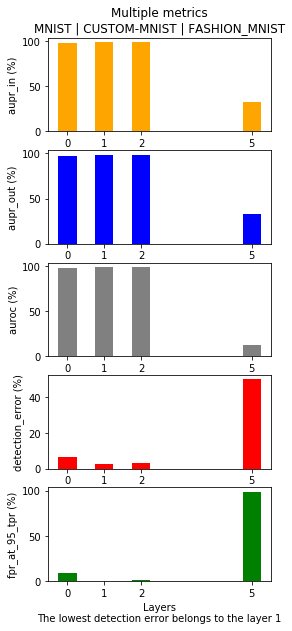

The lowest detection error belongs to the layer  1


In [11]:
x = slc_layers
bar_size=0.5
row_size = 5
figsize=(len(slc_layers),10)
fig = plt.figure(1, figsize=figsize)

plt.subplot(row_size, 1, 1)
plt.bar(x, aupr_in, width=bar_size, color="orange")
plt.title("Multiple metrics\n"+id_name+" | "+id_model+" | "+ood_ds_name)
plt.ylabel('aupr_in (%)')
plt.xticks(x)

plt.subplot(row_size, 1, 2)
plt.bar(x, aupr_out, width=bar_size, color="blue")
plt.ylabel('aupr_out (%)')
plt.xticks(x)

plt.subplot(row_size, 1, 3)
plt.bar(x, auroc, width=bar_size, color="gray")
plt.ylabel('auroc (%)')
plt.xticks(x)

plt.subplot(row_size, 1, 4)
plt.bar(x, detection_error, width=bar_size, color="red")
plt.ylabel('detection_error (%)')
plt.xticks(x)

plt.subplot(row_size, 1, 5)
plt.bar(x, fpr_at_95_tpr, width=bar_size, color="green")
plt.ylabel('fpr_at_95_tpr (%)')
plt.xticks(x)

plt.xlabel('Layers\n'+"The lowest detection error belongs to the layer "+\
                           str(slc_layers[np.argmin(detection_error)]))
plt.show()
print("The lowest detection error belongs to the layer ", str(slc_layers[np.argmin(detection_error)]))
fig.savefig(base_address+id_name+"-"+id_model+"-"+ood_ds_name+".png")